# Kinetic modeling

One of the main applications of metabolic RNA labeling is to model the kinetics of RNA expression levels [12](https://www.cell.com/molecular-cell/fulltext/S1097-2765(21)00496-2). The most natural and widely used model is to describe the change of RNA levels $a(t)$ and time $t$ is by the differential equation:

$$\frac{da}{dt} = \sigma - \delta \cdot a(t)$$

Here $\sigma$ is the net synthesis rate of RNA and $\delta$ is the degradation rate. This differential equation can be solved analytically (see e.g. [[1]](https://academic.oup.com/bioinformatics/article/34/13/i218/5045735)). Based on this, there are several ways implemented in grandPy to estimate both $\sigma$ and $\delta$. Here, we will see how to fit this model using non-linear least squares (NLLS) regression on the estimated new and old RNA levels [[2]](https://www.cell.com/molecular-cell/fulltext/S1097-2765(21)00496-2).

To perform an analysis of the RNA dynamics for data from [3](https://www.nature.com/articles/s41586-021-03610-3), we first load the grandPy package and then read the GRAND-SLAM output table directly from zenodo.

In [1]:
from Py.load import *
sars = read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.


C:\Users\User\PycharmProjects\grandpy\Py\utils.py:140: UserWarning: 17 Duplicate gene symbols found: STPG4, PDE11A, TXNRD3NB, ARL14EPL, HIST1H3D (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")


Refer to the [Loading data and working with grandPy objects](vignette_03_loading_data_and_working_with_grandPy_objects.ipynb) vignette to learn more about how to load data. Note that sample metadata has been automatically extracted from the sample names via the design parameter given to `read_grand`.

In [2]:
sars.coldata

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU
Name,,,,,,
Mock.no4sU.A,Mock.no4sU.A,Mock,0.0,no4sU,A,True
Mock.1h.A,Mock.1h.A,Mock,1.0,1h,A,False
Mock.2h.A,Mock.2h.A,Mock,2.0,2h,A,False
Mock.2h.B,Mock.2h.B,Mock,2.0,2h,B,False
Mock.3h.A,Mock.3h.A,Mock,3.0,3h,A,False
Mock.4h.A,Mock.4h.A,Mock,4.0,4h,A,False
SARS.no4sU.A,SARS.no4sU.A,SARS,0.0,no4sU,A,True
SARS.1h.A,SARS.1h.A,SARS,1.0,1h,A,False
SARS.2h.A,SARS.2h.A,SARS,2.0,2h,A,False


By default GRAND-SLAM will report data on all genes (with at least one mapped read) and `read_grand` will read all these genes from the output:

In [3]:
print(sars)

GrandPy:
Read from sars.tsv
19659 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



Thus, we filter to only include genes that have at least 100 reads in the at least 6 samples:

In [4]:
from Py.processing import *
sars = sars.filter_genes(min_expression=100, min_columns=6)
print(sars)

GrandPy:
Read from sars.tsv
9162 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



The actual data is available in so-called "data-slots". `read_grand` adds the read counts, new to total RNA rations (NTRs) and information on the NTR posterior distribution (alpha, beta).

As a quick quality check, we can inspect a principal component analysis of all samples involved:

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.96 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 0.99 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Fitting dispersions...
... done in 0.84 seconds.

C:\Users\User\PycharmProjects\grandpy\.venv\Lib\site-packages\pydeseq2\dds.py:431: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst=True)


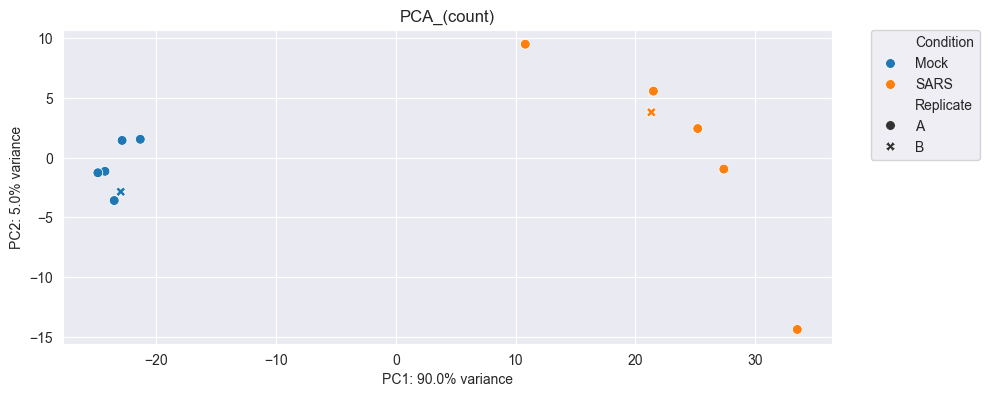

In [5]:
from Py.plot import *
plot_pca(sars)

# punktsymmetrisch?

The samples are colored according to the `Condition` annotation (see above in the Coldata table). `Condition` has a special meaning in grandPy, not only for `plot_pca`, but also for other analyses (see below). The `Condition` can be set conveniently using the `with_condition` function. For more information, see the [Loading data and working with grandPy objects](vignette_03_loading_data_and_working_with_grandPy_objects.ipynb) vignette. For `plot_pca`, the visual attributes can be adapted via a parameter (this is the mapping parameter to ggplot, and, thus, all names from the Coldata table can be used in expressions):

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.90 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.97 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Fitting dispersions...
... done in 0.89 seconds.

C:\Users\User\PycharmProjects\grandpy\.venv\Lib\site-packages\pydeseq2\dds.py:431: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst=True)


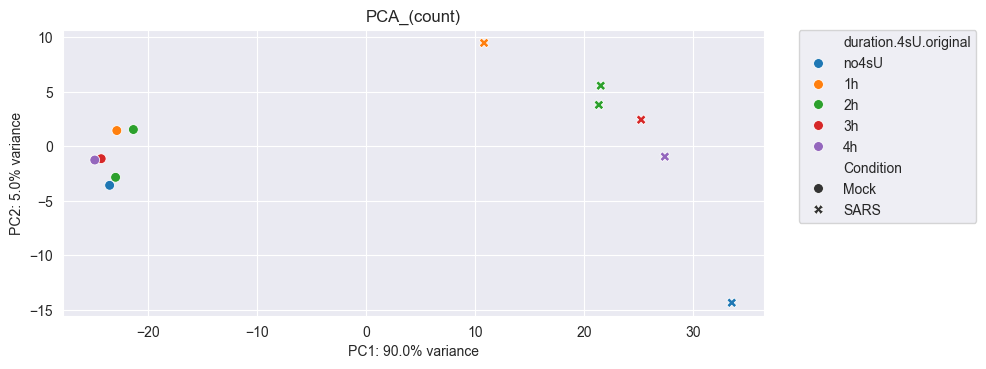

In [6]:
plot_pca(sars, aest={"color": "duration.4sU.original", "shape": "Condition"})
# ...

There are no obvious problems with the samples, even though the virus infected 3hpi sample is the top-most whereas the other virus infected samples are ordered along infection time from bottom to top. <span style="color:red">(?)</span>

For the NLLS approach it is important to normalize the data:

In [7]:
sars = sars.normalize()
print(sars)

GrandPy:
Read from sars.tsv
9162 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'norm']
Available analyses: []
Available plots: {}
Default data slot: norm



Make sure that the normalization you use here is appropriate. Calling `normalize` will add an additional slot which is set to be the default slot.

Before we conduct any kinetic modeling, we inspect the 4sU dropout plots:

In [ ]:
# R-Code:
# Plot4sUDropoutRankAll(subset(sars,Condition=="Mock"))